In [1]:
import sys

sys.path.append('../../')

import random
import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm

from sklearn import datasets
from dal_toolbox.models.deterministic.train import train_one_epoch
from dal_toolbox.models.deterministic.train import train_one_epoch_pseudolabel
from dal_toolbox.models.deterministic.train import train_one_epoch_pimodel
from dal_toolbox.models.deterministic.train import train_one_epoch_fixmatch

In [2]:
X, y = datasets.make_moons(250, noise=.05, random_state=42)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

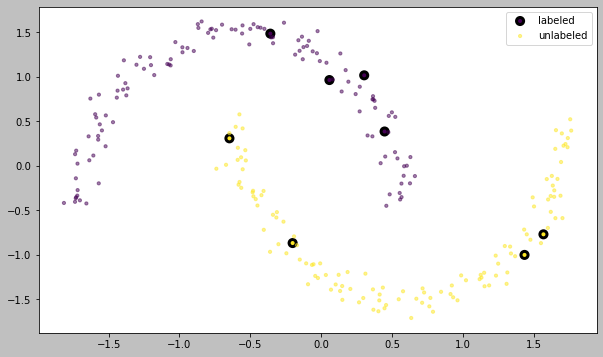

In [3]:
# Setup SSL 

class GaussianNoiseDataset(torch.utils.data.TensorDataset):
    def __init__(self, X, y, mean=0, std=1, noise=0.2):
        super(GaussianNoiseDataset, self).__init__(X, y)
        self.mean = mean
        self.std = std
        self.noise = noise
        assert noise >= 0 and noise <= 1, "noise is a probability and should be between 0 and 1"

    def __getitem__(self, idx):
        X, y = super().__getitem__(idx)
        X = X + torch.randn_like(X)*self.noise
        return X, y

random.seed(1)
indices_class0 = [i for i in range(len(y)) if y[i] == 0]
indices_class1 = [i for i in range(len(y)) if y[i] == 1]
labeled_indices = random.sample(indices_class0, k=4) + random.sample(indices_class1, k=4)
unlabeled_indices = [i for i in range(X.shape[0]) if i not in labeled_indices]

X_labeled, y_labeled = X[labeled_indices], y[labeled_indices]
X_unlabeled, y_unlabeled = X[unlabeled_indices], y[unlabeled_indices]

labeled_ds = torch.utils.data.TensorDataset(X_labeled, y_labeled)
unlabeled_ds = GaussianNoiseDataset(X_unlabeled, y_unlabeled, noise=0.0)
# Using labeled and unlabeled data for unsupervised learning
unlabeled_ds_weak = GaussianNoiseDataset(X, y, noise=0.05)
unlabeled_ds_strong = GaussianNoiseDataset(X, y, noise=0.25)

plt.figure(figsize=(10,6), facecolor='silver')
plt.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, s=50, edgecolors='black', linewidths=3, label='labeled')
plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=y_unlabeled, s=10, alpha=0.5, label='unlabeled')
plt.legend()
plt.show()

In [4]:
class Net(nn.Module):
    def __init__(self, num_classes: int, dropout_rate: int = 0, feature_dim: int = 128):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x, return_feature=False):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        if return_feature:
            return out, x
        return out

In [5]:
@torch.no_grad()
def plot_contour(model, X_l, y_l, X_u, y_u, ax=None):
    model.eval()
    model.cpu()
    origin = 'lower'
    if ax:
        plt.sca(ax)
    domain = 3
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51), indexing='ij')
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    plt.scatter(X_l[:, 0], X_l[:, 1], c=y_l, s=50, edgecolors='red')
    plt.scatter(X_u[:, 0], X_u[:, 1], c=y_u, s=1)
    CS = plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6), origin=origin)
    CS2 = plt.contour(CS, levels=[0.5], colors='black', origin=origin)
    cbar = plt.colorbar(CS)
    cbar.add_lines(CS2)

## Supervised Training

Epoch [0] [ 0/10] eta: 0:00:00 lr: 0.01 loss: 0.6937 (0.6937) acc1: 50.0000 (50.0000) time: 0.0039 data: 0.0003 max mem: 1
Epoch [0] Total time: 0:00:00
Epoch [1] [ 0/10] eta: 0:00:00 lr: 0.01 loss: 0.4367 (0.4367) acc1: 87.5000 (87.5000) time: 0.0018 data: 0.0005 max mem: 1
Epoch [1] Total time: 0:00:00
Epoch [2] [ 0/10] eta: 0:00:00 lr: 0.01 loss: 0.2285 (0.2285) acc1: 87.5000 (87.5000) time: 0.0012 data: 0.0002 max mem: 1
Epoch [2] Total time: 0:00:00
Epoch [3] [ 0/10] eta: 0:00:00 lr: 0.01 loss: 0.1206 (0.1206) acc1: 100.0000 (100.0000) time: 0.0011 data: 0.0003 max mem: 1
Epoch [3] Total time: 0:00:00
Epoch [4] [ 0/10] eta: 0:00:00 lr: 0.01 loss: 0.0578 (0.0578) acc1: 100.0000 (100.0000) time: 0.0013 data: 0.0003 max mem: 1
Epoch [4] Total time: 0:00:00
Epoch [5] [ 0/10] eta: 0:00:00 lr: 0.01 loss: 0.0314 (0.0314) acc1: 100.0000 (100.0000) time: 0.0013 data: 0.0003 max mem: 1
Epoch [5] Total time: 0:00:00
Epoch [6] [ 0/10] eta: 0:00:00 lr: 0.01 loss: 0.0203 (0.0203) acc1: 100.0000

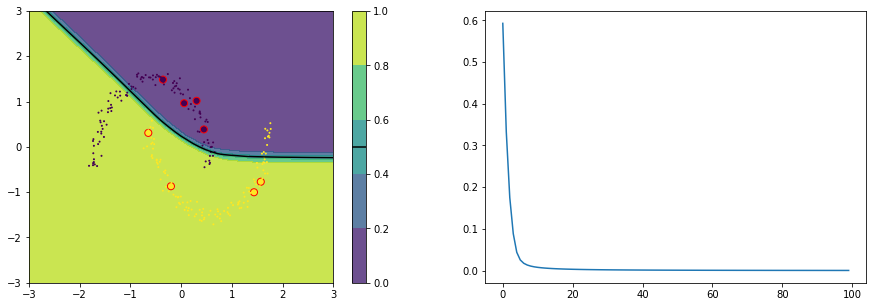

In [26]:
# Supervised model
torch.manual_seed(0)

n_epochs=100
n_iter = 1000
batch_size = 32

n_iter_per_epoch = n_iter // n_epochs
sampler = RandomSampler(labeled_ds, num_samples=n_iter_per_epoch*batch_size)
labeled_loader = DataLoader(labeled_ds, batch_size=batch_size, sampler=sampler)

supervised_optimizer_params = dict(lr=0.01, weight_decay=1e-4, momentum=.9)
supervised_model = Net(dropout_rate=0, num_classes=2)
supervised_optimizer = torch.optim.SGD(supervised_model.parameters(), **supervised_optimizer_params)

criterion = nn.CrossEntropyLoss()

history = []
for i in range(n_epochs):
    train_stats = train_one_epoch(supervised_model, labeled_loader, criterion, supervised_optimizer, device='cuda', epoch=i)
    history.append(train_stats)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plot_contour(supervised_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled)
plt.subplot(122)
plt.plot([d['train_loss'] for d in history])
plt.show()

## Pseudo-Labeling

Epoch [0] [  0/100] eta: 0:00:00 lr: 0.01 loss: 0.6937 (0.6937) sup_loss: 0.6937 (0.6937) unsup_loss: 0.0000 (0.0000) mask_ratio: 0.0000 (0.0000) unsup_warmup_factor: 0.0000 (0.0000) acc1: 50.0000 (50.0000) time: 0.0080 data: 0.0002 max mem: 1
Epoch [0] Total time: 0:00:00
Epoch [1] [  0/100] eta: 0:00:00 lr: 0.01 loss: 0.0084 (0.0084) sup_loss: 0.0080 (0.0080) unsup_loss: 0.0019 (0.0019) mask_ratio: 0.7500 (0.7500) unsup_warmup_factor: 0.0250 (0.0250) acc1: 100.0000 (100.0000) time: 0.0021 data: 0.0002 max mem: 1
Epoch [1] Total time: 0:00:00
Epoch [2] [  0/100] eta: 0:00:00 lr: 0.01 loss: 0.0037 (0.0037) sup_loss: 0.0029 (0.0029) unsup_loss: 0.0017 (0.0017) mask_ratio: 0.8750 (0.8750) unsup_warmup_factor: 0.0500 (0.0500) acc1: 100.0000 (100.0000) time: 0.0027 data: 0.0003 max mem: 1
Epoch [2] Total time: 0:00:00
Epoch [3] [  0/100] eta: 0:00:00 lr: 0.01 loss: 0.0038 (0.0038) sup_loss: 0.0015 (0.0015) unsup_loss: 0.0031 (0.0031) mask_ratio: 0.8750 (0.8750) unsup_warmup_factor: 0.0750 

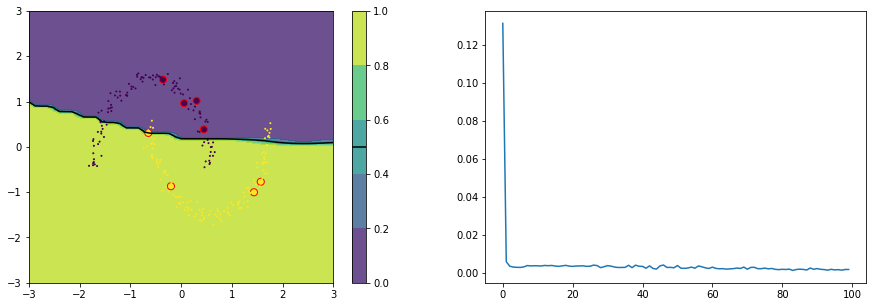

In [27]:
# Pseudolabels Model
torch.manual_seed(0)

n_epochs=100
n_iter = 10000
batch_size = 32

n_iter_per_epoch = n_iter // n_epochs
sampler = RandomSampler(labeled_ds, num_samples=n_iter_per_epoch*batch_size)
labeled_loader = DataLoader(labeled_ds, batch_size=batch_size, sampler=sampler)

unlabeled_ds = GaussianNoiseDataset(X_unlabeled, y_unlabeled, noise=0.1)
sampler = RandomSampler(unlabeled_ds, num_samples=n_iter_per_epoch*batch_size)
unlabeled_loader = DataLoader(unlabeled_ds, batch_size=batch_size, sampler=sampler)
dataloaders = {"train_sup": labeled_loader, "train_unsup": unlabeled_loader}

n_iter_per_epoch = n_iter // n_epochs
sampler = RandomSampler(labeled_ds, num_samples=n_iter_per_epoch*batch_size)
labeled_loader = DataLoader(labeled_ds, batch_size=batch_size, sampler=sampler)

pseudo_optimizer_params = dict(lr=0.01, weight_decay=0.0001, momentum=.9,)
pseudo_model = Net(dropout_rate=0, num_classes=2)
pseudo_optimizer = torch.optim.SGD(pseudo_model.parameters(), **pseudo_optimizer_params)


history = []
for i in range(n_epochs):
    train_stats = train_one_epoch_pseudolabel(
        model=pseudo_model, dataloaders=dataloaders, criterion=criterion, 
        optimizer=pseudo_optimizer, device='cuda', epoch=i, unsup_warmup=0.4, lambda_u=10, use_hard_labels=True,
        n_iter=n_iter, p_cutoff=0.95)
    history.append(train_stats)

pseudo_model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(121)
plot_contour(pseudo_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled)
plt.subplot(122)
plt.plot([d['train_loss'] for d in history])
plt.show()

## Pi-Model

Epoch [0] [  0/100] eta: 0:00:00 lr: 0.01 loss: 0.6937 (0.6937) sup_loss: 0.6937 (0.6937) unsup_loss: 0.0000 (0.0000) unsup_warmup_factor: 0.0000 (0.0000) acc1: 50.0000 (50.0000) time: 0.0033 data: 0.0004 max mem: 1
Epoch [0] Total time: 0:00:00
Epoch [1] [  0/100] eta: 0:00:00 lr: 0.01 loss: 0.0197 (0.0197) sup_loss: 0.0087 (0.0087) unsup_loss: 0.0146 (0.0146) unsup_warmup_factor: 0.0250 (0.0250) acc1: 100.0000 (100.0000) time: 0.0026 data: 0.0002 max mem: 1
Epoch [1] Total time: 0:00:00
Epoch [2] [  0/100] eta: 0:00:00 lr: 0.01 loss: 0.0060 (0.0060) sup_loss: 0.0046 (0.0046) unsup_loss: 0.0009 (0.0009) unsup_warmup_factor: 0.0500 (0.0500) acc1: 100.0000 (100.0000) time: 0.0025 data: 0.0002 max mem: 1
Epoch [2] Total time: 0:00:00
Epoch [3] [  0/100] eta: 0:00:00 lr: 0.01 loss: 0.0410 (0.0410) sup_loss: 0.0034 (0.0034) unsup_loss: 0.0167 (0.0167) unsup_warmup_factor: 0.0750 (0.0750) acc1: 100.0000 (100.0000) time: 0.0024 data: 0.0002 max mem: 1
Epoch [3] Total time: 0:00:00
Epoch [4] 

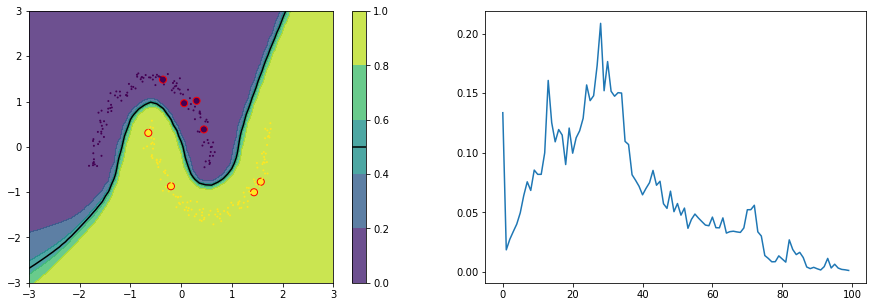

In [28]:
# Pimodel
torch.manual_seed(0)

n_epochs=100
n_iter = 10000
batch_size = 32

n_iter_per_epoch = n_iter // n_epochs
sampler = RandomSampler(labeled_ds, num_samples=n_iter_per_epoch*batch_size)
labeled_loader = DataLoader(labeled_ds, batch_size=batch_size, sampler=sampler)

unlabeled_ds.noise = 0.1
unlabeled_sampler1 = RandomSampler(unlabeled_ds, generator=torch.Generator().manual_seed(42), num_samples=n_iter_per_epoch*batch_size)
unlabeled_sampler2 = RandomSampler(unlabeled_ds, generator=torch.Generator().manual_seed(42), num_samples=n_iter_per_epoch*batch_size)
unlabeled_loader1 = DataLoader(unlabeled_ds, batch_size=batch_size, sampler=unlabeled_sampler1)
unlabeled_loader2 = DataLoader(unlabeled_ds, batch_size=batch_size, sampler=unlabeled_sampler2)
pi_loaders = {
        "train_sup": labeled_loader,
        "train_unsup_weak_1": unlabeled_loader1,
        "train_unsup_weak_2": unlabeled_loader2
}

pi_optimizer_params = dict(lr=0.01, weight_decay=0.0001, momentum=.9,)
pi_model = Net(dropout_rate=0, num_classes=2)
pi_optimizer = torch.optim.SGD(pi_model.parameters(), **pi_optimizer_params)

history = []
for i in range(n_epochs):
    train_stats = train_one_epoch_pimodel(
        model=pi_model, dataloaders=pi_loaders, criterion=criterion, 
        optimizer=pi_optimizer, device='cuda', epoch=i, unsup_warmup=0.4, lambda_u=30,
        n_iter=n_iter)
    history.append(train_stats)

pi_model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(121)
plot_contour(pi_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled)
plt.subplot(122)
plt.plot([d['train_loss'] for d in history])
plt.show()

## Fixmatch

Epoch [0] [ 0/50] eta: 0:00:00 lr: 0.01 sup_loss: 0.6937 (0.6937) unsup_loss: 0.0000 (0.0000) total_loss: 0.6937 (0.6937) acc1: 50.0000 (50.0000) time: 0.0046 data: 0.0003 max mem: 1
Epoch [0] Total time: 0:00:00
Epoch [1] [ 0/50] eta: 0:00:00 lr: 0.01 sup_loss: 0.0166 (0.0166) unsup_loss: 0.0022 (0.0022) total_loss: 0.0383 (0.0383) acc1: 100.0000 (100.0000) time: 0.0027 data: 0.0002 max mem: 1
Epoch [1] Total time: 0:00:00
Epoch [2] [ 0/50] eta: 0:00:00 lr: 0.01 sup_loss: 0.1316 (0.1316) unsup_loss: 0.0097 (0.0097) total_loss: 0.2289 (0.2289) acc1: 87.5000 (87.5000) time: 0.0042 data: 0.0002 max mem: 1
Epoch [2] Total time: 0:00:00
Epoch [3] [ 0/50] eta: 0:00:00 lr: 0.01 sup_loss: 0.2545 (0.2545) unsup_loss: 0.0223 (0.0223) total_loss: 0.4779 (0.4779) acc1: 87.5000 (87.5000) time: 0.0019 data: 0.0002 max mem: 1
Epoch [3] Total time: 0:00:00
Epoch [4] [ 0/50] eta: 0:00:00 lr: 0.01 sup_loss: 0.0124 (0.0124) unsup_loss: 0.0211 (0.0211) total_loss: 0.2237 (0.2237) acc1: 100.0000 (100.0000

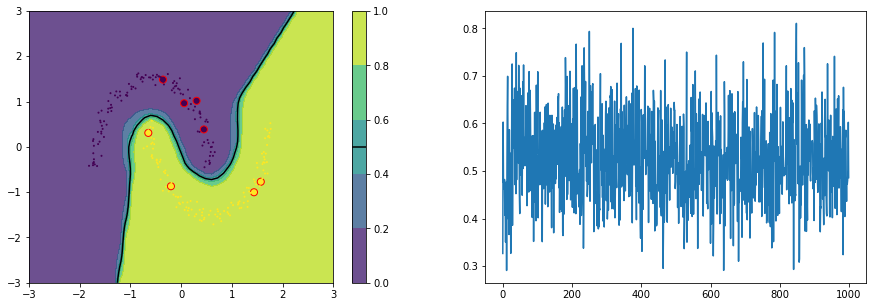

In [24]:
# Fixmatch
torch.manual_seed(0)

n_epochs=1000
n_iter = 50000
u_ratio = 3
batch_size = 8

n_iter_per_epoch = n_iter // n_epochs
labeled_sampler = RandomSampler(labeled_ds, num_samples=n_iter_per_epoch*batch_size)
labeled_loader = DataLoader(labeled_ds, batch_size=batch_size, sampler=labeled_sampler)

unlabeled_sampler1 = RandomSampler(unlabeled_ds_weak, generator=torch.Generator().manual_seed(42), num_samples=u_ratio*n_iter_per_epoch*batch_size)
unlabeled_sampler2 = RandomSampler(unlabeled_ds_strong, generator=torch.Generator().manual_seed(42), num_samples=u_ratio*n_iter_per_epoch*batch_size)
unlabeled_loader1 = DataLoader(unlabeled_ds_weak, batch_size=u_ratio*batch_size, sampler=unlabeled_sampler1)
unlabeled_loader2 = DataLoader(unlabeled_ds_strong, batch_size=u_ratio*batch_size, sampler=unlabeled_sampler2)
fix_loaders = {
        "train_sup": labeled_loader,
        "train_unsup_weak": unlabeled_loader1,
        "train_unsup_strong": unlabeled_loader2
}

fix_optimizer_params = dict(lr=0.01, weight_decay=0.0001, momentum=.9,)
fix_model = Net(dropout_rate=0, num_classes=2)
fix_optimizer = torch.optim.SGD(fix_model.parameters(), **fix_optimizer_params)
criterion = nn.CrossEntropyLoss()

history = []
for i in range(n_epochs):
    train_stats = train_one_epoch_fixmatch(
        model=fix_model, dataloaders=fix_loaders, criterion=criterion, 
        optimizer=fix_optimizer, device='cuda', epoch=i, lambda_u=10, T=0.5,
        use_cat=True, p_cutoff=0.95, use_hard_labels=True)
    history.append(train_stats)

fix_model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(121)
plot_contour(fix_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled)
plt.subplot(122)
plt.plot([d['train_total_loss'] for d in history])
plt.show()

## Comparison

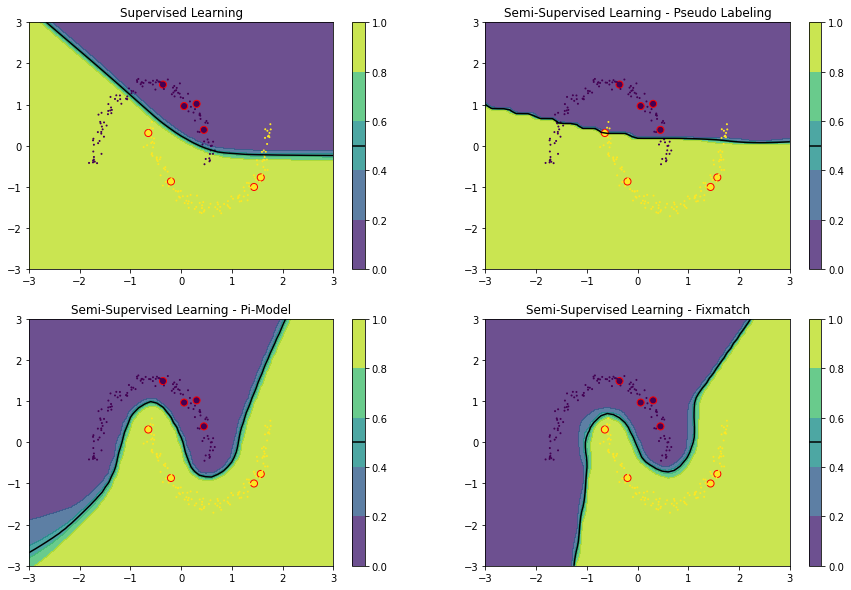

In [31]:
# Plot results
supervised_model.eval()
pseudo_model.eval()
pi_model.eval()
fix_model.eval()

fig, axis = plt.subplots(2, 2, figsize=(15,10))
axis[0][0].set_title('Supervised Learning')
plot_contour(supervised_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled, ax=axis[0][0])
axis[0][1].set_title('Semi-Supervised Learning - Pseudo Labeling')
plot_contour(pseudo_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled, ax=axis[0][1])
axis[1][0].set_title('Semi-Supervised Learning - Pi-Model')
plot_contour(pi_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled, ax=axis[1][0])
axis[1][1].set_title('Semi-Supervised Learning - Fixmatch')
plot_contour(fix_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled, ax=axis[1][1])
plt.show()